### 🙋‍♂️***알라딘 카테고리 별 BestSeller 데이터 수집***
- 알라딘 측에서 발급받은 TTB KEY 사용
- json 파일을 Data Frame 형태로 변환

In [ ]:
import requests
import json
import pandas as pd
import numpy as np

In [ ]:
def getBookData():
    TTB_KEY = ''
    params = {
            'ttbkey':TTB_KEY,
            'QueryType':'Bestseller',
            'MaxResults':'50',
            'SearchTarget':'Book',
            'output':'JS',
            'Version':'20131101',
            'Cover':'Big'}

    cat_list = {
            '소설/시/희곡':'1',
            '경제경영': '170',
            '과학':'987',
            '사회과학':'798',
            '에세이':'55889',
            '역사':'74',
            '예술/대중문화':'517',
            '인문학':'656',
            '자기계발':'336',
            '장르소설':'112011',
            '가정/요리/뷰티':'1230',
            '건강/취미/레저':'55890',
            '좋은부모':'2030',
            '컴퓨터/모바일':'351',
            '여행':'1196',
            '청소년':'1137',
            '고전':'2105'}

    df = pd.DataFrame()             # 도서 정보를 저장할 데이터 프레임 생성
    for cat_name in cat_list.values():
        for page in range(1, 15):   # 총 결과는 1,000개까지만 조회 가능(페이지 당 50권)
            API_URL = f'http://www.aladin.co.kr/ttb/api/ItemList.aspx?Start={page}&CategoryId={cat_name}'
    
            raw_data = requests.get(API_URL, params=params)
            parsed_data = json.loads(raw_data.text, strict=False)
            df = pd.concat([df, pd.DataFrame(parsed_data['item'])])
    return df

df = getBookData()
df.head()

,title,link,author,pubDate,description,isbn,isbn13,itemId,priceSales,priceStandard,mallType,stockStatus,mileage,cover,categoryId,categoryName,publisher,salesPoint,adult,fixedPrice,customerReviewRank,bestRank,subInfo,seriesInfo
0,불편한 편의점,http://www.aladin.co.kr/shop/wproduct.aspx?Ite...,김호연 (지은이),2021-04-20,&lt;망원동 브라더스&gt;의 작가 김호연의 '동네이야기' 시즌 2. 청파동 골목...,K582730818,9791161571188,269428498,12600,14000,BOOK,,700,https://image.aladin.co.kr/product/26942/84/co...,50993,국내도서>소설/시/희곡>한국소설>2000년대 이후 한국소설,나무옆의자,277127,False,True,10,1,{},NaN
1,이방인 2,http://www.aladin.co.kr/shop/wproduct.aspx?Ite...,선명 (지은이),2022-02-24,연우정의 세계에 조금씩 스며들던 지호의 앞에 아버지가 나타난다. 오백이란 빚을 지고...,K332836111,9791167790651,289210224,12600,14000,BOOK,예약판매,700,https://image.aladin.co.kr/product/28921/2/cov...,181723,국내도서>소설/시/희곡>로맨스소설>국내 BL,영컴(YOUNG COM),24250,True,True,10,2,{},NaN
2,"어서 오세요, 휴남동 서점입니다",http://www.aladin.co.kr/shop/wproduct.aspx?Ite...,황보름 (지은이),2022-01-17,크고 작은 상처와 희망을 가진 사람들이 휴남동 서점이라는 공간을 안식처로 삼아 함께...,K362836265,9791197377143,286859586,13500,15000,BOOK,,750,https://image.aladin.co.kr/product/28685/95/co...,50993,국내도서>소설/시/희곡>한국소설>2000년대 이후 한국소설,클레이하우스,72845,False,True,9,3,{},NaN
3,밝은 밤,http://www.aladin.co.kr/shop/wproduct.aspx?Ite...,최은영 (지은이),2021-07-27,"공감을 불러일으키는 이야기와 서정적이며 사려 깊은 문장, 그리고 그 안에 자리한 뜨...",K312835925,9788954681179,275419192,13050,14500,BOOK,,720,https://image.aladin.co.kr/product/27541/91/co...,50993,국내도서>소설/시/희곡>한국소설>2000년대 이후 한국소설,문학동네,164650,False,True,10,4,{},NaN
4,백광,http://www.aladin.co.kr/shop/wproduct.aspx?Ite...,"렌조 미키히코 (지은이), 양윤옥 (옮긴이)",2022-02-14,세상이 전부 녹아내릴 듯 뜨겁던 여름날. 어느 가정집 안마당에서 네 살 난 여자아이...,K652836302,9791191043617,288756034,13050,14500,BOOK,,720,https://image.aladin.co.kr/product/28875/60/co...,51058,국내도서>소설/시/희곡>추리/미스터리소설>일본 추리/미스터리소설,모모,19560,False,True,10,5,{},NaN


In [ ]:
# 원본 데이터 csv 파일로 저장
df.to_csv('/content/drive/MyDrive/books_origin.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/books_origin.csv',index_col=0)

### 🙋‍♂️***데이터 전처리 및 특성 추출***

In [ ]:
pip install konlpy

In [ ]:
from konlpy.tag import Komoran
import re

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/books_origin.csv',index_col=0)

In [ ]:
def preprocessing(df):
    # 사용하지 않을 컬럼 삭제
    drop_list = ['isbn', 'itemId', 'priceSales', 'mallType', 'stockStatus', 'mileage', 'categoryId', 'adult', 'fixedPrice', 'subInfo', 'seriesInfo', 'priceStandard', 'customerReviewRank', 'bestRank']
    df = df.drop(drop_list, axis=1)

    # 결측치 제거
    df.dropna(inplace=True)

    # ISBN 번호 기준 중복 도서 제거
    df.drop_duplicates(['isbn13'], keep='first', inplace=True)

    # 정규표현식을 사용한 제목 내 특수문자 및 설명 제거
    df['title'] = df['title'].str.replace('\(.*\)|\s-\s.*|\s:\s.*|(\+).+', '', regex=True)

    # author 특성은 지은이, 옮긴이, 엮은이, 그린이 등이 모두 표기
    # 예) 타케마치 (지은이), 토마리 (그림), 송재희 (옮긴이)

    # 지은이 추출 (첫 괄호 앞 까지)
    df['writer'] = df['author'].str.replace('\(.*\)', '', regex=True)

    # 옮긴이 추출 (번역서인 경우)
    def getTranslator(authors):
        authors = str(authors).split(',')
        translator = None
        for author in authors:
            if '옮긴이' in author:
                translator = re.sub('\(.*\)', '', author)
        return translator
    df['translator'] = df['author'].apply(getTranslator)

    # 출간일 데이터 분리
    df['pubDate'] = pd.to_datetime(df['pubDate'])
    df['pubYear'] = df['pubDate'].dt.year       # 연
    df['pubMonth'] = df['pubDate'].dt.month     # 월
    df['pubDay'] = df['pubDate'].dt.day         # 일

    # 카테고리 분리
    categories = df['categoryName'].str.split('>')
    df['1stClass'] = categories.str.get(1)  # 첫번째 값은 전부 '국내도서'이기 때문에 제외
    df['2ndClass'] = categories.str.get(2)
    df['3rdClass'] = categories.str.get(3)  # 세번째 카테고리가 없는 경우 NaN처리
    
    # 상품 설명에서 키워드 추출
    komoran = Komoran()

    # 반복문 전 인덱스 재정렬
    df = df.reset_index(drop=True)
    
    keyword = []
    for i in range(len(df)):
        if df['description'][i] != None:
            # 이스케이프 문자 제거
            description = re.sub('\s'," ", df['description'][i])   
            words = set(komoran.nouns(description))
        clearn_words = []

        for word in words:
            if len(word) != 1:  # 한 자릿 수 단어 제거
                clearn_words.append(word) 
        # 키워드 중 최대 7개 사용
        words = {}
        keyword.append(clearn_words[:7])
        
    # 키워드 데이터와 기존 데이터 프레임 병합
    keyword = pd.Series((i for i in keyword), name='keyword')
    df = pd.concat([df, keyword], axis=1)

    # 사용하지 않는 컬럼 제거
    df.drop(['pubDate', 'categoryName', 'author', 'description'], axis=1, inplace=True)

    # DB에 저장하기 위해 NaN값 None으로 처리
    df = df.where(pd.notnull(df), None)

    # 컬럼명 변경
    df.rename(columns = {'isbn13': 'ISBN'}, inplace=True)

    return df

In [ ]:
df = preprocessing(df)

In [ ]:
df.to_csv('/content/drive/MyDrive/books_df.csv', encoding='utf-8-sig')

In [ ]:
drop_list = ['keyword', 'pubYear', 'pubMonth', 'pubDay']
df.drop(drop_list, axis=1, inplace=True)

In [ ]:
# keyword 제외하고 postgreSQL DB에 저장(csv 형태로 import)
df.to_csv('/content/drive/MyDrive/books.csv', encoding='utf-8-sig')

### 🙋‍♂️***데이터 시각화***
1. 시대별 도서 카테고리(대분류)의 트렌드가 있을까?
2. 2000년대 이후 카테고리(대분류) 별 출시량 대비 salepoint 추이는 어떨까?
3. 소설/시/희곡(대분류)에서 시대별로 가장 사랑받은 카테고리(중분류)는 무엇일까?
4. 경제경영(대분류)의 중분류 출판량은 시대별로 어떻게 변화했을까?
4. 소설/시/희곡에서 시대별로 가장 사랑받은 출판사는 어디일까?

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/books_df.csv', index_col=0)

In [ ]:
df.head(1)

,title,link,ISBN,cover,publisher,salesPoint,writer,translator,pubYear,pubMonth,pubDay,1stClass,2ndClass,3rdClass,keyword
0,불편한 편의점,http://www.aladin.co.kr/shop/wproduct.aspx?Ite...,9791161571188,https://image.aladin.co.kr/product/26942/84/co...,나무옆의자,277127,김호연,NaN,2021,4,20,소설/시/희곡,한국소설,2000년대 이후 한국소설,"['브라더스', '작가', '시즌', '자리', '모퉁이', '시대', '희로애락']"


#### 🌟 1. 시대별 도서 카테고리(대분류)의 트렌드가 있을까?

In [ ]:
df['1stClass'].value_counts()

소설/시/희곡      1416
인문학           783
에세이           660
경제경영          645
좋은부모          603
컴퓨터/모바일       587
건강/취미/레저      583
자기계발          544
청소년           494
예술/대중문화       487
역사            486
사회과학          472
가정/요리/뷰티      417
과학            369
여행            305
대학교재/전문서적     206
어린이            70
종교/역학          57
만화             39
외국어            13
유아             11
잡지              9
고전              6
중학교참고서          5
고등학교참고서         3
수험서/자격증         2
Name: 1stClass, dtype: int64

In [ ]:
# 연도 범위 확인
print('pubYear column max value: ', df['pubYear'].max())
print('pubYear column min value: ', df['pubYear'].min())

pubYear column max value:  2022
pubYear column min value:  1981


In [ ]:
# 카테고리(대분류) 및 출판 연도를 사용해 피벗테이블 생성
cat_df = pd.pivot_table(df[['pubYear','1stClass']], index=pd.cut(df['pubYear'], np.array([1980, 1989, 1999, 2009, 2019, 2022])), columns='1stClass', aggfunc='count')
cat_df = cat_df.T
cat_df.reset_index(level=0, drop=True, inplace=True)    # 멀티 인덱스 제거

cat_df.head()

pubYear,"(1980, 1989]","(1989, 1999]","(1999, 2009]","(2009, 2019]","(2019, 2022]"
1stClass,,,,,
가정/요리/뷰티,0,1,5,172,239
건강/취미/레저,0,2,12,294,275
경제경영,0,0,24,174,447
고등학교참고서,0,0,0,1,2
고전,0,1,1,4,0


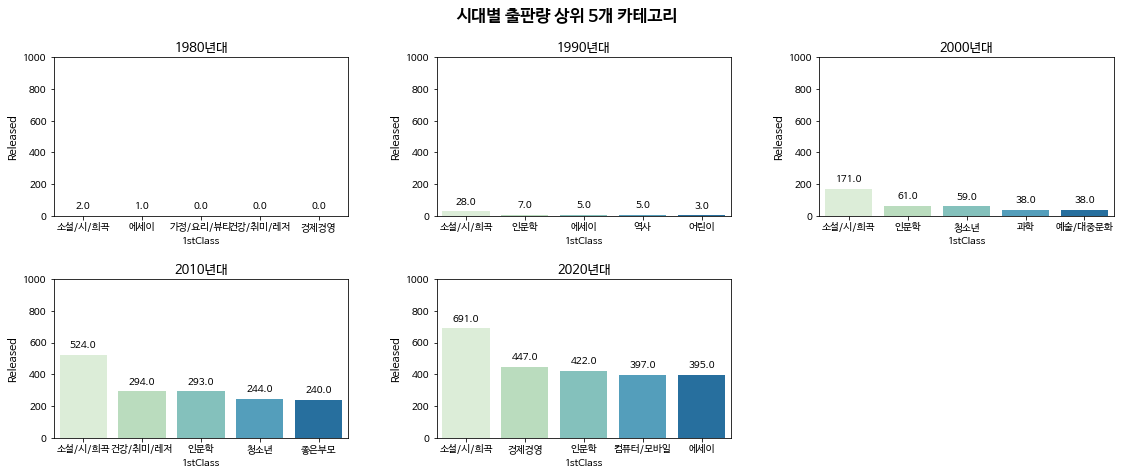

In [ ]:
fig = plt.figure(5, figsize=(19,7))
colors = sns.color_palette('mako')

plt.suptitle('시대별 출판량 상위 5개 카테고리', fontsize=17, fontweight='bold')
plt.subplots_adjust(wspace=0.3, hspace=0.4)

year = ['1980년대', '1990년대', '2000년대', '2010년대', '2020년대']
year_col = cat_df.columns.to_list()

for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.title(year[i], fontsize=13)

    data = cat_df.iloc[:,i].nlargest(5)
    plot = sns.barplot(x=data.index, y=data.values, palette='GnBu')
    
    for p in plot.patches:  # 그래프에 값 표시하기
        plot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
    plt.ylim([0, 1000])     # y축 범위 지정
    plt.ylabel('Released', fontsize=11)
plt.show()

- 소설/시/희곡은 시대를 막론하고 가장 많이 베스트셀러를 차지한 카테고리이다.
- 인문학은 90년대부터 꾸준히 인기를 얻은 카테고리이다.
- 2020년대에는 이제껏 상위권에 있지 않았던 경제경영, 컴퓨터/모바일 분야의 책이 많이 출간되었다.

#### 🌟 2. 2000년대 이후 카테고리(대분류) 별 ***출시량 대비 sale point*** 추이는 어떨까?

In [ ]:
# sales point 범위 확인
df['salesPoint'].describe()

count      9272.000000
mean       6768.090272
std       13681.178338
min          60.000000
25%        1500.000000
50%        3169.500000
75%        6731.250000
max      344924.000000
Name: salesPoint, dtype: float64

In [ ]:
sales_df = df[df['pubYear'] >= 2000]    # 2000년대 이후 도서 추출                              

sales_df = sales_df[['salesPoint', '1stClass']].groupby('1stClass').agg({'salesPoint':'sum', '1stClass':'count'})
sales_df.rename(columns = {'1stClass':'count'}, inplace=True)    # 컬럼 명 변경
sales_df = sales_df.nlargest(10, 'salesPoint')                   # 상위 10개 데이터 사용
sales_df

,salesPoint,count
1stClass,,
소설/시/희곡,14119784,1386
경제경영,7176163,645
인문학,6910907,776
에세이,5700239,654
자기계발,4919195,544
사회과학,3193576,470
좋은부모,2959107,601
청소년,2886215,492
예술/대중문화,2861917,484


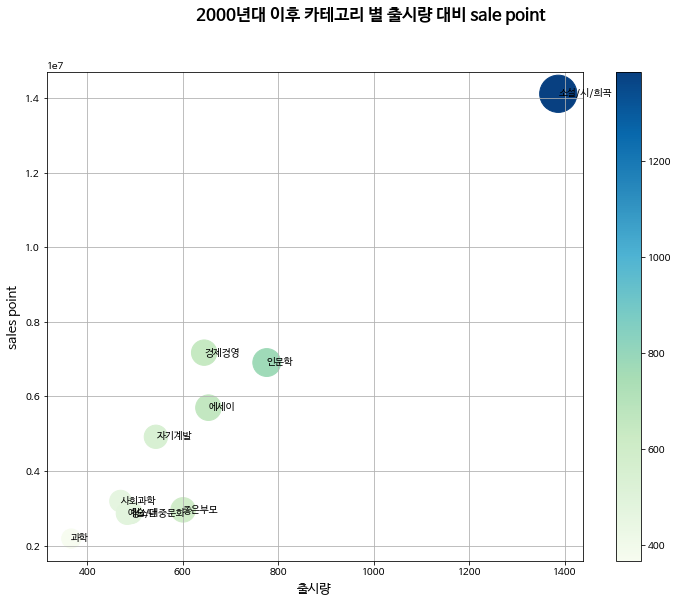

In [ ]:
fig = plt.figure(figsize=(12, 9))

plt.suptitle('2000년대 이후 카테고리 별 출시량 대비 sale point', fontsize=17, fontweight='bold')

plt.scatter(data=sales_df, x='count', y='salesPoint',
            s='count', c='count', cmap=plt.cm.GnBu)

for x, y, s, country in zip(sales_df['count'], sales_df['salesPoint'], sales_df['count'], sales_df.index):
    plt.text(x, y, country, va='center')

plt.grid(True)
plt.colorbar()

plt.ylabel('sales point', fontsize=13)
plt.xlabel('출시량', fontsize=13)
plt.show()

- 2000년대 이후 소설/시/희곡 도서는 출시량과 sales point가 다른 카테고리에 비해 압도적으로 많았다.
- 인문학 도서는 출시량이 두번째로 많았지만, sales point는 경제 경영 도서와 비슷했다.

#### 🌟 3. ***소설/시/희곡(대분류)***에서 시대별로 가장 사랑받은 카테고리(중분류)는 무엇일까?

In [ ]:
# 대분류 카테고리를 받아 시대별 중분류 도서 수 데이터 프레임을 반환하는 함수
def getSecondCat(cat_name):
    second_df = df[df['1stClass'] == cat_name]
    second_df = pd.pivot_table(second_df[['pubYear','2ndClass']], index=pd.cut(second_df['pubYear'], np.array([1980, 1989, 1999, 2009, 2019, 2022])), columns='2ndClass', aggfunc='count')

    second_df = second_df.T
    second_df.reset_index(level=0, drop=True, inplace=True)

    return second_df

In [ ]:
# 데이터 프레임을 받아 시대별 상위 5대 카테고리의 pie chart를 반환하는 함수
def getSecondCatPie(cat_name, df):
    fig = plt.figure(4, figsize=(12,12))
    colors = sns.color_palette('mako')

    plt.suptitle(f'{cat_name} 분야의 시대별 상위 5개 카테고리(중분류)', fontsize=17, fontweight='bold')
    year_col = df.columns.to_list()
    year = ['1980년대', '1990년대', '2000년대', '2010년대', '2020년대']
    
    # 도서가 거의 출간되지 않은 80년대는 제외
    for i in range(1, 5):   
        plt.subplot(2, 2, i)

        plt.title(year[i], fontsize=14.5, fontweight='bold')
        
        # top 5 데이터 선택
        data = df.iloc[:,i].nlargest(5)  
        top5_list = data.index.to_list()

        # top 5가 아닌 데이터 other로 설정
        other = df.iloc[:,i].drop(index = top5_list)  
        data.loc['기타'] = other.sum()
    
        # 라벨명 맞추기
        labels = data.index.tolist()            
        _, _, autopcts = plt.pie(data, startangle=90, counterclock=False, colors = colors, autopct='%.0f%%')
        plt.legend(labels, loc='upper right', bbox_to_anchor=(1.2, 1))           # 범례표시
        plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':10})   # 퍼센트 값 흰색으로 설정

In [ ]:
novel_df = getSecondCat('소설/시/희곡')
novel_df.head()

pubYear,"(1980, 1989]","(1989, 1999]","(1999, 2009]","(2009, 2019]","(2019, 2022]"
2ndClass,,,,,
과학소설(SF),0,1,7,32,67
독일소설,0,5,10,15,17
라이트 노벨,0,0,0,21,93
러시아소설,0,2,13,27,10
로맨스소설,0,0,1,22,56


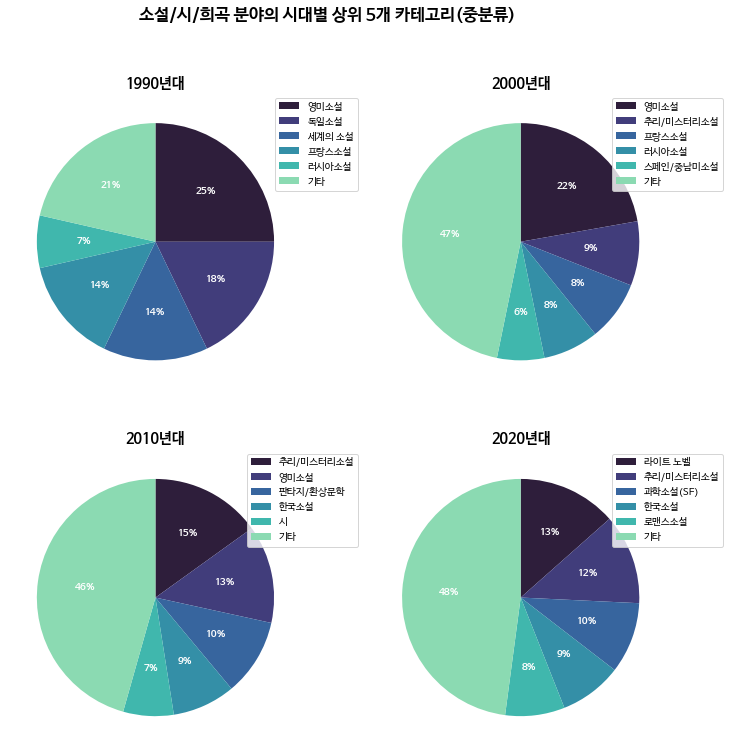

In [ ]:
getSecondCatPie('소설/시/희곡', novel_df)

- 영미소설, 추리/미스터리 소설은 꾸준히 인기있었다.
- 2010년대 부터 한국소설이 다시 인기를 끌었다. 이 시기부터 문단에서 젊은 작가들이 주목받기 시작했다. 
- 2020년대에는 과학소설(SF)분야가 새롭게 상위 카테고리에 올랐다. 과학 기술에 대한 관심과 더불어 김초엽, 천선란, 황모과 등 젊은 여성 작가들의 약진이 두드러졌다.
- 2020년대의 또 다른 특이점은 라이트 노벨이다. 라이트노벨은 일본에서 시작된 장르로 만화/애니메이션 풍의 일러스트가 들어간 소설 장르이다. 차트에서 가장 많은 비율을 차지했다.

#### 🌟 4. ***경제경영(대분류)***의 중분류 출판량은 시대별로 어떻게 변화했을까?

In [ ]:
economic_df = getSecondCat('경제경영')
economic_df.head()

pubYear,"(1980, 1989]","(1989, 1999]","(1999, 2009]","(2009, 2019]","(2019, 2022]"
2ndClass,,,,,
CEO/비즈니스맨을 위한 능력계발,0,0,0,6,3
[경제경영 사상가 20인],0,0,2,4,9
[포브스 100대 기업],0,0,0,3,4
경제학/경제일반,0,0,4,20,52
기업 경영,0,0,1,14,66


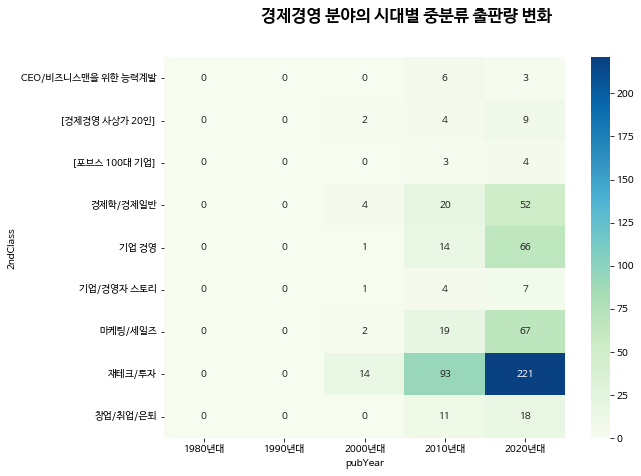

In [ ]:
fig = plt.figure(4, figsize=(9,7))
plt.suptitle('경제경영 분야의 시대별 중분류 출판량 변화', fontsize=17, fontweight='bold')
ax = sns.heatmap(economic_df, 
                 annot=True,    # 표에 숫자 표시 
                 fmt='d',       # 정수형으로 포매팅 
                 cbar=True,     # 컬러바 표시
                 xticklabels=year,
                 cmap=plt.cm.GnBu)

- 한 카테고리(CEO/비즈니스맨을 위한 능력개발)를 제외하고는 모든 카테고리에서 출판량이 시대에 따라 증가했다. 
- 특히 재태크/투자 카테고리의 인기가 2020년대 들어서 많이 증가했다. 이는 코로나 19의 영향이 컸다고 할 수 있다. 주식과 부동산뿐만 아니라 가상화폐, 메타버스 등 새로운 투자방식에 대한 사람들의 관심이 지속되고 있다.

#### 🌟 5. 카테고리별 인기있는 ***출판사***는 어디일까?

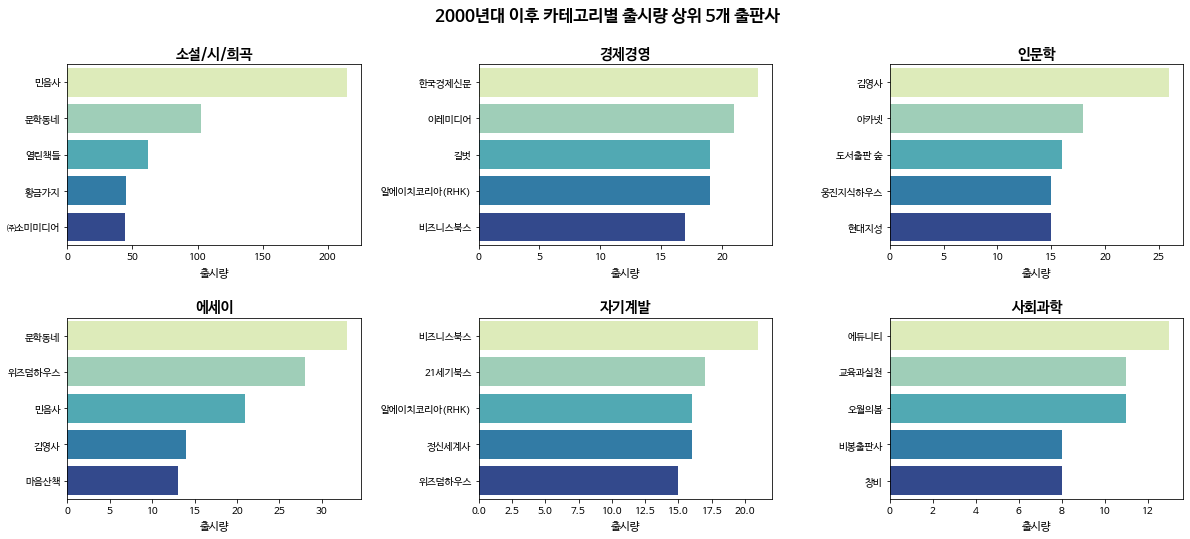

In [ ]:
pub_df = df[df['pubYear'] >= 2000]
top5_cat_list = sales_df.nlargest(6, 'salesPoint').index.to_list()  # salesPoint기준 상위 5개 카테고리만 선택

fig = plt.figure(5, figsize=(20,8))
plt.suptitle('2000년대 이후 카테고리별 출시량 상위 5개 출판사', fontsize=17, fontweight='bold')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(len(top5_cat_list)):
    plt.subplot(2, 3, i+1)
    plt.title(top5_cat_list[i], fontsize=14.5, fontweight='bold')

    data = pub_df[pub_df['1stClass']==top5_cat_list[i]].groupby('publisher').size().nlargest(5)
    plot = sns.barplot(x=data.values, y=data.index, palette='YlGnBu')

    plt.xlabel('출시량', fontsize=11)
    plt.ylabel('')
plt.show()

- 민음사와 황금가지는 같은 민음사 출판그룹으로, 소설/시/희곡 분야에서 민음사의 입지가 크다는 것을 알 수 있다.